# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
import math
import joblib
import random


# 2. Data Visualisation, Preprocessing, and Feature Engineering

In [2]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


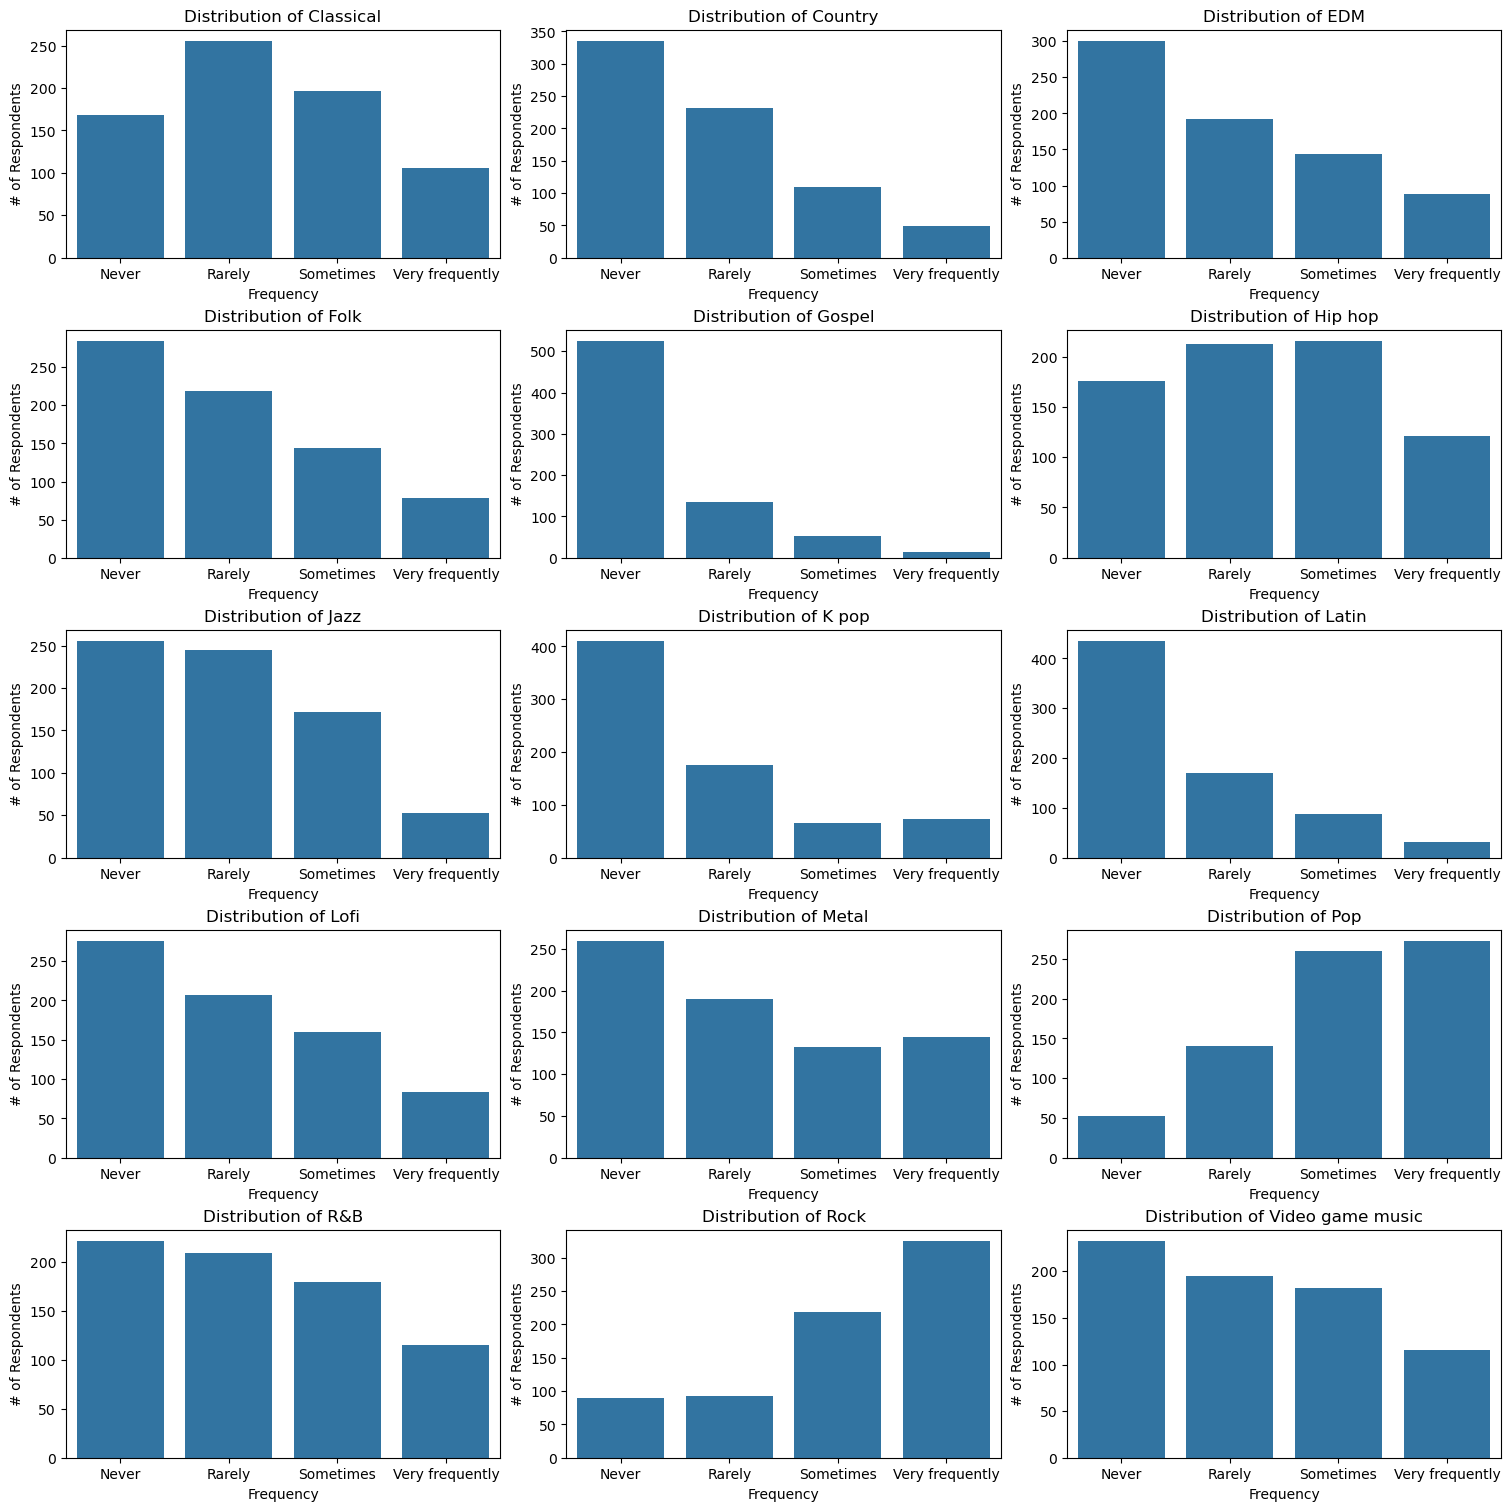

In [12]:
# Plot the distribution of each genre frequency in a grid
genre = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in genre:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [ ]:
# Drop gospel and latin, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]', 'Frequency [Latin]'])

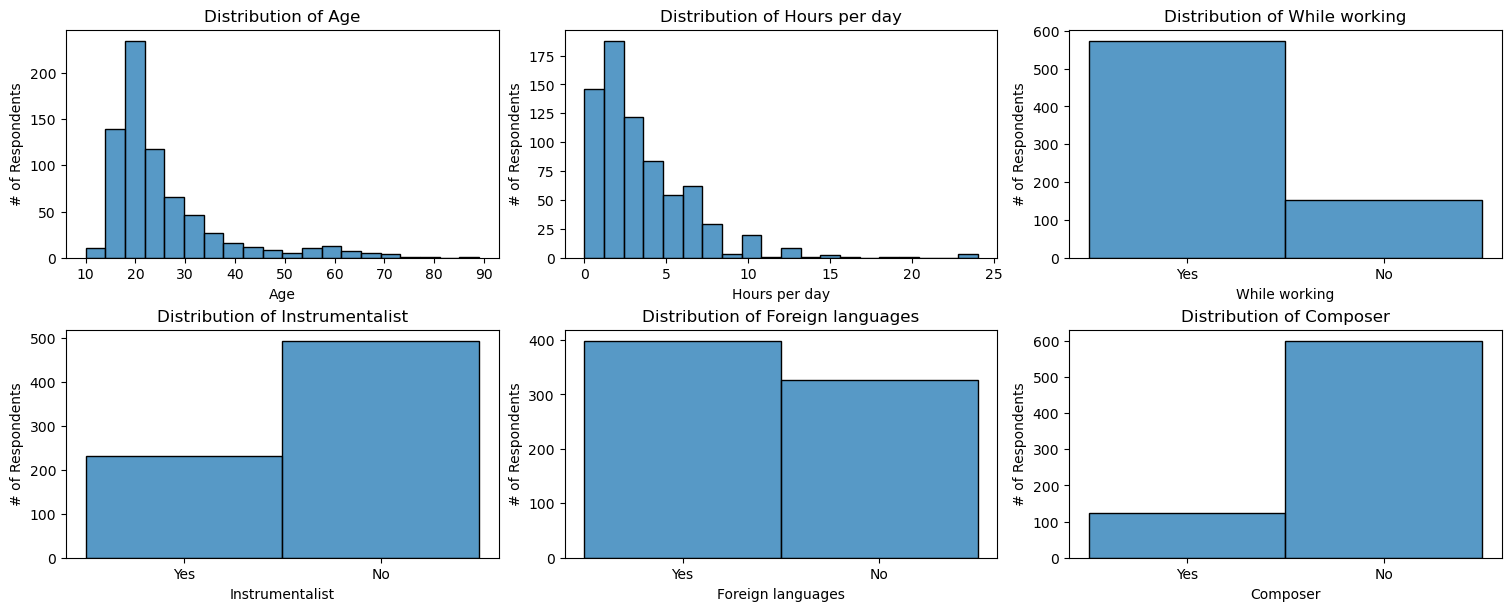

In [4]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

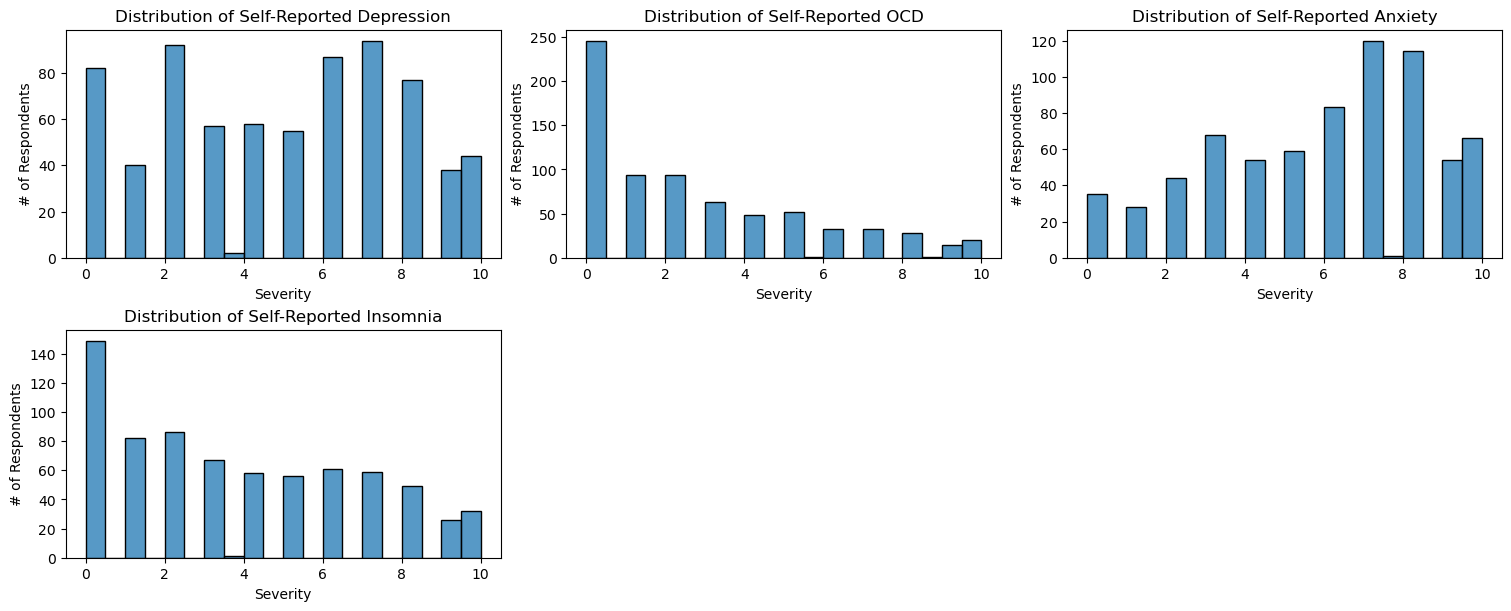

In [5]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [9]:
# Display summary statistics of the dataset
df.describe()

,Age,Hours per day,Anxiety_class,Depression_class,Insomnia_class,OCD_class
count,726.000000,726.000000,726.000000,726.000000,726.000000,726.000000
mean,25.241047,3.564807,1.247934,0.975207,0.699725,0.446281
std,12.081723,3.006324,0.818217,0.849790,0.817515,0.713810
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,21.000000,3.000000,1.000000,1.000000,0.000000,0.000000
75%,28.000000,5.000000,2.000000,2.000000,1.000000,1.000000
max,89.000000,24.000000,2.000000,2.000000,2.000000,2.000000


In [6]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [7]:
# Convert favourite genre into a boost applied to the users favourite genre frequency

# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

fav_genre_boost = 1.0   # Boost amount 1.0 to add to favourite genre frequency

# Convert favourite genre into frequency column name
def convert_fav_genre_to_freq_col(genre):
    return f"Frequency [{genre}]"

# Apply boost to favourite genre frequency
for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + fav_genre_boost

# Drop original Fav genre column 
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [8]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# Identify Yes/No columns
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

# Conver true false to binary 1/0
for col in df_fe1.columns:
    if df_fe1[col].dtype == bool:
        df_fe1[col] = df_fe1[col].astype(int)

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe

# Save the final preprocessed dataframe to a new CSV file
processed_data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df_fe1.to_csv(processed_data_path, index=False)

# Print message to confirm saving
print(f"Processed data saved to {processed_data_path}")


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Gospel]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Latin]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']
Processed data saved to c:\Users\hanna\Documents\DS3000\DS3000-Group-4\Data\mxmh_survey_results_processed.csv


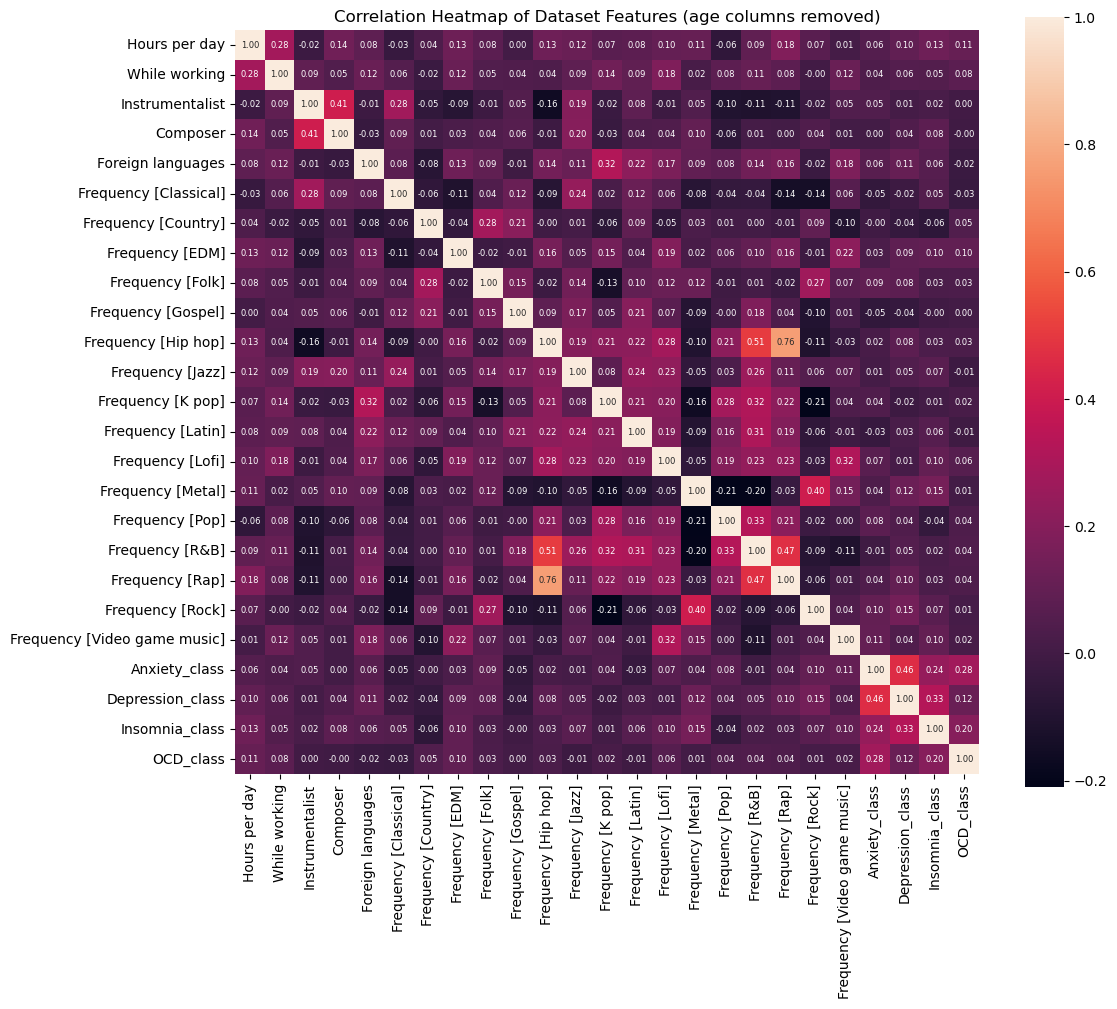

In [19]:
# Create a correlation heatmap for the dataset

# Drop any one-hot encoded AgeGroup columns so the matrix excludes age bins
age_cols = [c for c in df_fe1.columns if str(c).startswith('AgeGroup')]
if age_cols:
    corr_df = df_fe1.drop(columns=age_cols)
else:
    corr_df = df_fe1

corr = corr_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size': 6}, square=True)
plt.title("Correlation Heatmap of Dataset Features (age columns removed)")
plt.show()

No individual correlations between genres and conditions can be observed here. However, we do notice a positive correlation between those who listen to Rap and Hip Hop, as well as Hip Hop and R&B.

Below we will conduct 3 experiments to investigate the correlation between music listening preferences/habits and mental health condition severity.

# XGBoost Experiment

[I 2025-12-01 21:28:51,576] A new study created in memory with name: no-name-9270a505-8601-486e-a4e9-d4d1006cbb46
[I 2025-12-01 21:28:51,814] Trial 0 finished with value: 0.38306094561277154 and parameters: {'n_estimators': 268, 'learning_rate': 0.09438618395919757, 'max_depth': 6, 'subsample': 0.798337034488342, 'colsample_bytree': 0.7159989439246586, 'gamma': 0.945359667384361, 'min_child_weight': 6}. Best is trial 0 with value: 0.38306094561277154.
[I 2025-12-01 21:28:51,814] Trial 0 finished with value: 0.38306094561277154 and parameters: {'n_estimators': 268, 'learning_rate': 0.09438618395919757, 'max_depth': 6, 'subsample': 0.798337034488342, 'colsample_bytree': 0.7159989439246586, 'gamma': 0.945359667384361, 'min_child_weight': 6}. Best is trial 0 with value: 0.38306094561277154.
[I 2025-12-01 21:28:51,978] Trial 1 finished with value: 0.34592906321862554 and parameters: {'n_estimators': 164, 'learning_rate': 0.13813516677471935, 'max_depth': 3, 'subsample': 0.830485896830278, '

Best hyperparameters: {'n_estimators': 197, 'learning_rate': 0.12369910797363182, 'max_depth': 4, 'subsample': 0.9443331376343634, 'colsample_bytree': 0.8954914391314117, 'gamma': 0.39075324574453074, 'min_child_weight': 7}

Evaluation on test set:
Accuracy: 0.4452054794520548
Precision: 0.3196428571428571
Recall: 0.3414151576123407
F1 Score: 0.3021135500602019
ROC AUC: 0.571745423529904

Classification report:
              precision    recall  f1-score   support

           0       0.25      0.17      0.20        35
           1       0.20      0.05      0.08        40
           2       0.51      0.80      0.62        71

    accuracy                           0.45       146
   macro avg       0.32      0.34      0.30       146
weighted avg       0.36      0.45      0.37       146


Evaluation on test set:
Accuracy: 0.4452054794520548
Precision: 0.3196428571428571
Recall: 0.3414151576123407
F1 Score: 0.3021135500602019
ROC AUC: 0.571745423529904

Classification report:
             

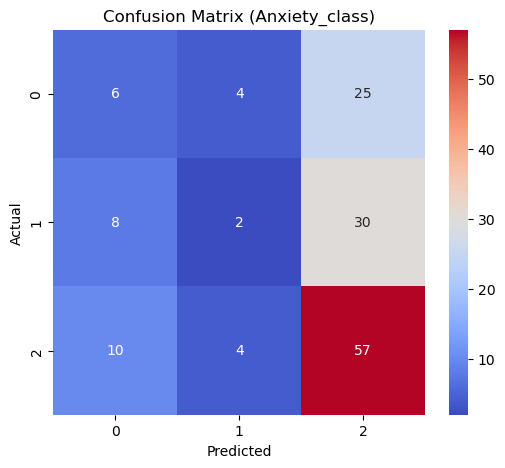

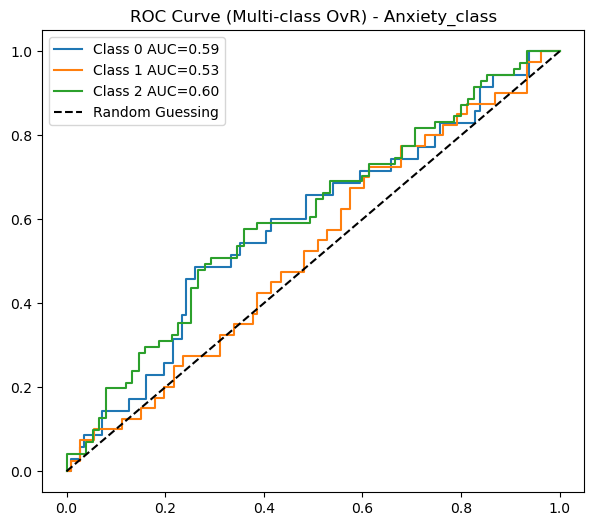

[I 2025-12-01 21:29:00,093] A new study created in memory with name: no-name-514f15cb-d209-413b-86be-17055ba2b921


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 21:29:00,622] Trial 0 finished with value: 0.36551276610329464 and parameters: {'n_estimators': 160, 'learning_rate': 0.03476582498863151, 'max_depth': 4, 'subsample': 0.8618585605189224, 'colsample_bytree': 0.6704536314544749, 'gamma': 0.7808098506681689, 'min_child_weight': 10}. Best is trial 0 with value: 0.36551276610329464.
[I 2025-12-01 21:29:01,071] Trial 1 finished with value: 0.38191170305579214 and parameters: {'n_estimators': 312, 'learning_rate': 0.03853068290134946, 'max_depth': 3, 'subsample': 0.86101940901121, 'colsample_bytree': 0.7916814128858203, 'gamma': 1.2270548801316048, 'min_child_weight': 6}. Best is trial 1 with value: 0.38191170305579214.
[I 2025-12-01 21:29:01,071] Trial 1 finished with value: 0.38191170305579214 and parameters: {'n_estimators': 312, 'learning_rate': 0.03853068290134946, 'max_depth': 3, 'subsample': 0.86101940901121, 'colsample_bytree': 0.7916814128858203, 'gamma': 1.2270548801316048, 'min_child_weight': 6}. Best is trial 1 with

Best hyperparameters: {'n_estimators': 264, 'learning_rate': 0.026214110442850595, 'max_depth': 8, 'subsample': 0.8002504590707444, 'colsample_bytree': 0.8536135781846254, 'gamma': 0.19576649191156814, 'min_child_weight': 2}

Evaluation on test set:
Accuracy: 0.410958904109589
Precision: 0.3886304648262379
Recall: 0.39583222629611914
F1 Score: 0.3883877103654647
ROC AUC: 0.6126288327133839

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.46      0.46        54
           1       0.28      0.20      0.23        41
           2       0.44      0.53      0.48        51

    accuracy                           0.41       146
   macro avg       0.39      0.40      0.39       146
weighted avg       0.40      0.41      0.40       146


Evaluation on test set:
Accuracy: 0.410958904109589
Precision: 0.3886304648262379
Recall: 0.39583222629611914
F1 Score: 0.3883877103654647
ROC AUC: 0.6126288327133839

Classification report:
          

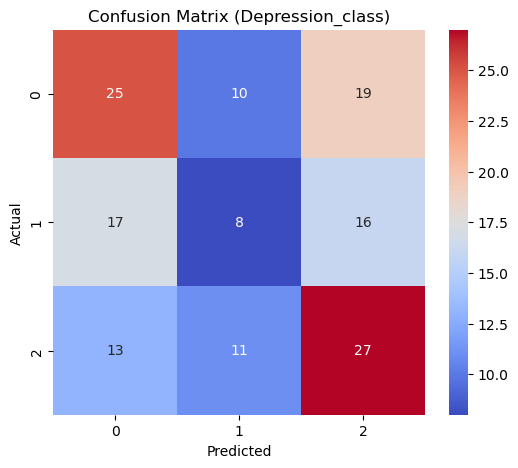

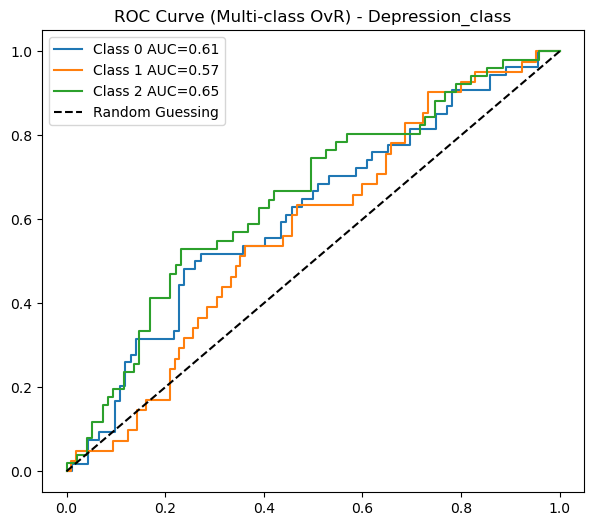

[I 2025-12-01 21:29:13,559] A new study created in memory with name: no-name-48bc14fe-ba2f-41f6-a063-3ff13a2228dc


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_depression_model.pkl


[I 2025-12-01 21:29:14,120] Trial 0 finished with value: 0.32325507832922235 and parameters: {'n_estimators': 322, 'learning_rate': 0.12102522152047412, 'max_depth': 6, 'subsample': 0.9730959165571431, 'colsample_bytree': 0.6191669252094936, 'gamma': 0.901333932711988, 'min_child_weight': 8}. Best is trial 0 with value: 0.32325507832922235.
[I 2025-12-01 21:29:14,419] Trial 1 finished with value: 0.3671995381378513 and parameters: {'n_estimators': 108, 'learning_rate': 0.0898722189815544, 'max_depth': 7, 'subsample': 0.9321847604867088, 'colsample_bytree': 0.6564328333413255, 'gamma': 0.2206969103174945, 'min_child_weight': 5}. Best is trial 1 with value: 0.3671995381378513.
[I 2025-12-01 21:29:14,419] Trial 1 finished with value: 0.3671995381378513 and parameters: {'n_estimators': 108, 'learning_rate': 0.0898722189815544, 'max_depth': 7, 'subsample': 0.9321847604867088, 'colsample_bytree': 0.6564328333413255, 'gamma': 0.2206969103174945, 'min_child_weight': 5}. Best is trial 1 with va

Best hyperparameters: {'n_estimators': 316, 'learning_rate': 0.032760903233843876, 'max_depth': 6, 'subsample': 0.763439061883566, 'colsample_bytree': 0.775363718732737, 'gamma': 0.1606840913513138, 'min_child_weight': 5}

Evaluation on test set:
Accuracy: 0.4657534246575342
Precision: 0.34345142243692967
Recall: 0.34295334295334295
F1 Score: 0.3244240038357686
ROC AUC: 0.5262691639086405

Classification report:
              precision    recall  f1-score   support

           0       0.55      0.77      0.64        77
           1       0.27      0.11      0.16        36
           2       0.22      0.15      0.18        33

    accuracy                           0.47       146
   macro avg       0.34      0.34      0.32       146
weighted avg       0.40      0.47      0.42       146


Evaluation on test set:
Accuracy: 0.4657534246575342
Precision: 0.34345142243692967
Recall: 0.34295334295334295
F1 Score: 0.3244240038357686
ROC AUC: 0.5262691639086405

Classification report:
         

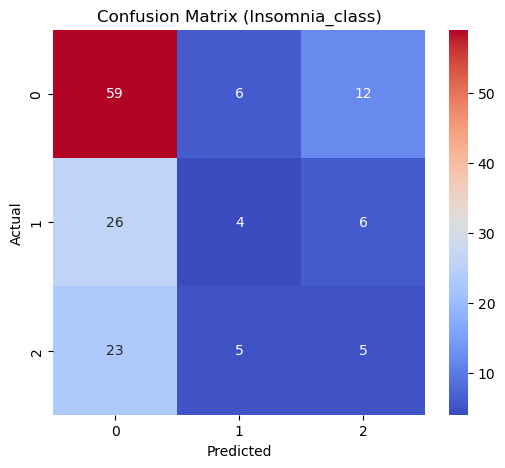

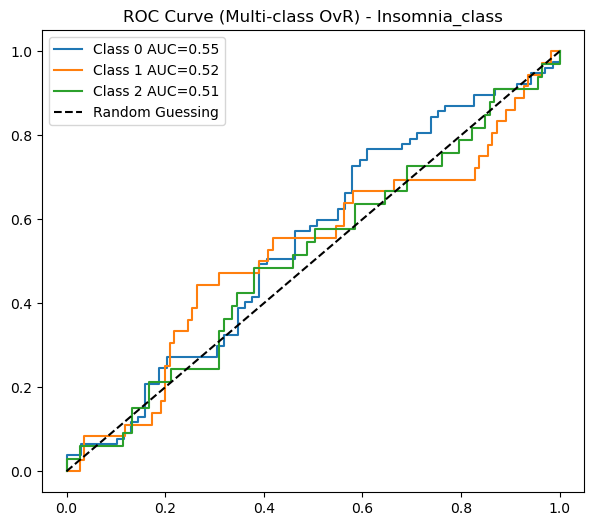

[I 2025-12-01 21:29:28,886] A new study created in memory with name: no-name-d23175ff-3a0c-4076-bc36-9270d271653d


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_insomnia_model.pkl


[I 2025-12-01 21:29:29,181] Trial 0 finished with value: 0.3253025831176369 and parameters: {'n_estimators': 117, 'learning_rate': 0.06849763722339254, 'max_depth': 6, 'subsample': 0.7595562337734563, 'colsample_bytree': 0.8295029869416457, 'gamma': 0.2953354296979207, 'min_child_weight': 7}. Best is trial 0 with value: 0.3253025831176369.
[I 2025-12-01 21:29:29,423] Trial 1 finished with value: 0.3323330148158455 and parameters: {'n_estimators': 112, 'learning_rate': 0.16632425895378902, 'max_depth': 5, 'subsample': 0.722184308007801, 'colsample_bytree': 0.9229657330985712, 'gamma': 0.33249426876952315, 'min_child_weight': 10}. Best is trial 1 with value: 0.3323330148158455.
[I 2025-12-01 21:29:29,423] Trial 1 finished with value: 0.3323330148158455 and parameters: {'n_estimators': 112, 'learning_rate': 0.16632425895378902, 'max_depth': 5, 'subsample': 0.722184308007801, 'colsample_bytree': 0.9229657330985712, 'gamma': 0.33249426876952315, 'min_child_weight': 10}. Best is trial 1 with

Best hyperparameters: {'n_estimators': 237, 'learning_rate': 0.18626177417035766, 'max_depth': 4, 'subsample': 0.7933502984421803, 'colsample_bytree': 0.9366319471952761, 'gamma': 0.20856068559089608, 'min_child_weight': 7}

Evaluation on test set:
Accuracy: 0.6438356164383562
Precision: 0.3299259259259259
Recall: 0.3583950617283951
F1 Score: 0.33777777777777773
ROC AUC: 0.5017439408780323

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       100
           1       0.28      0.19      0.22        27
           2       0.00      0.00      0.00        19

    accuracy                           0.64       146
   macro avg       0.33      0.36      0.34       146
weighted avg       0.54      0.64      0.58       146


Evaluation on test set:
Accuracy: 0.6438356164383562
Precision: 0.3299259259259259
Recall: 0.3583950617283951
F1 Score: 0.33777777777777773
ROC AUC: 0.5017439408780323

Classification report:
         

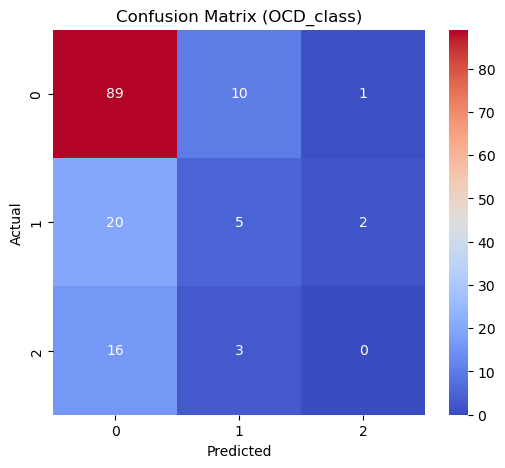

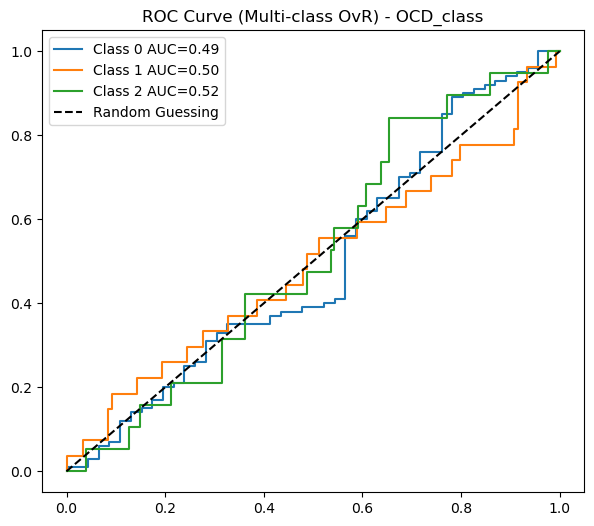

Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [20]:
# Reusable training + optuna hyperparameter tuning function for any target (e.g., Anxiety_class, Depression_class, Insomnia_class, OCD_class)
# Optuna is a hyperparameter optimisation framework

# Define function to train, tune, evaluate, and save model
def train_and_eval(target_col, n_trials=50, random_state=42):
    
    # Prepare data based on target column
    if target_col not in df_fe1.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe.")

    # Exclude other target columns
    exclude_cols = [c for c in df_fe1.columns if c.endswith('_class')]

    # Prepare features and target
    X = df_fe1.copy().drop(columns=exclude_cols)
    y = df_fe1[target_col].copy()

    # Split data into 80% train and 20% test, stratified by target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Preprocessor (numeric features pipeline)
    num_features = X_train.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")), # Impute missing values with median
                ("scale", StandardScaler()) # Scale numeric features
            ]), num_features) # All features are numeric
        ]
    )

    # Optuna objective function, which trains and evaluates model with given hyperparameters
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "random_state": random_state,
            "n_jobs": 1
        }

        # Create XGBoost model with trial params
        model = XGBClassifier(**params) 

        # Build pipeline
        pipe = Pipeline([("prep", preprocessor), ("model", model)])

        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = [] # Collect F1 scores across folds

        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_val)
            score = f1_score(y_val, preds, average="macro")
            scores.append(score)
        return np.mean(scores) # Return average F1 score across folds

    # Create and optimise study to maximise F1 score by tuning hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Print best performing hyperparameters
    print("Best hyperparameters:", study.best_params)

    # Train final model with best params on full training set
    best_params = study.best_params
    final_model = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist", random_state=random_state, n_jobs=-1)
    final_pipe = Pipeline([("prep", preprocessor), ("model", final_model)])
    final_pipe.fit(X_train, y_train)

    # Evaluate on test set
    preds = final_pipe.predict(X_test)
    proba = final_pipe.predict_proba(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")
    try:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), proba, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    # Print evaluation results
    print("\nEvaluation on test set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({target_col})")
    plt.show()

    # Plot ROC curves if available
    if roc_auc is not None:
        plt.figure(figsize=(7,6))
        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        for i in range(proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
        plt.legend()
        plt.title(f"ROC Curve (Multi-class OvR) - {target_col}")
        plt.show()

    # Save model
    safe_name = target_col.replace('_class','').lower()
    model_path = os.path.join(os.path.dirname(current_dir), 'models', f'xgboost_{safe_name}_model.pkl')
    joblib.dump(final_pipe, model_path)
    print("Saved model to:", model_path)

    return {"target": target_col, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, "model_path": model_path}

# Run for both Anxiety and Depression (if available)
results = {}
for target in ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']:
    if target in df_fe1.columns:
        results[target] = train_and_eval(target, n_trials=30)
    else:
        print(f"Skipping {target}: column not present")


# MLP Experiment



In [25]:
# Testing with just Depression_class
X = df_fe1.drop(['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class'], axis = 1)
y = df_fe1['Depression_class']

# Split the data into train, validation and test and hold out 20% and 10% of observations as the validation and test set, respectively. Pass random_state=42.
#First split 70% into train and then another 30% into temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
#Split the 30% into 20% for validation and 10% for testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)